### Importing the necessary libraries & Loading the data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
# import streamlit as st
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image

fashion_df = pd.read_csv("./data/fashion.csv")

## Basic Data Analysis

### Basic statistics - Number of products, subcategories & gender

In [7]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


### Frequency of each gender

In [8]:
fashion_df["Gender"].value_counts()

Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64

### Distribution of products gender-wise

/home/mario/anaconda3/envs/tensorflow/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Girls'),
 Text(1, 0, 'Boys'),
 Text(2, 0, 'Men'),
 Text(3, 0, 'Women')]

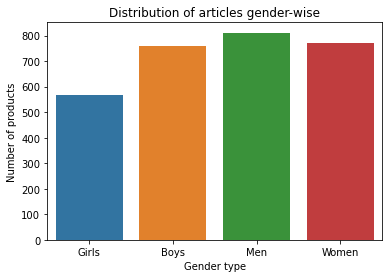

In [9]:
plot = sns.countplot(fashion_df["Gender"])
plt.title("Distribution of articles gender-wise")
plt.xlabel("Gender type")
plt.ylabel("Number of products")
plot.set_xticklabels(plot.get_xticklabels())

## Data Preparation

In [10]:
apparel_boys = fashion_df[fashion_df["Gender"]=="Boys"]
apparel_girls = fashion_df[fashion_df["Gender"]=="Girls"]
footwear_men = fashion_df[fashion_df["Gender"]=="Men"]
footwear_women = fashion_df[fashion_df["Gender"]=="Women"]

## Feature extraction using ResNet

In [14]:
img_width, img_height = 224, 224

#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "./data/Footwear/Men/Images/"

nb_train_samples = 811
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((811, 100352))
    
    np.save(open('./Men_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('./Men_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 811 images belonging to 1 classes.


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node resnet50/conv1_conv/Conv2D (defined at <ipython-input-14-771d1c74be65>:22) ]] [Op:__inference_predict_function_30427]

Function call stack:
predict_function


## Computing the Euclidean distance and recommending the similar products

### Loading pretrained model & the data subset

In [7]:
extracted_features = np.load('./Men_ResNet_features.npy')
Productids = np.load('./Men_ResNet_feature_product_ids.npy')

men = pd.read_csv('./footwear_men.csv')
df_Productids = list(men['ProductId'])
Productids = list(Productids)

==================== input product image ====================


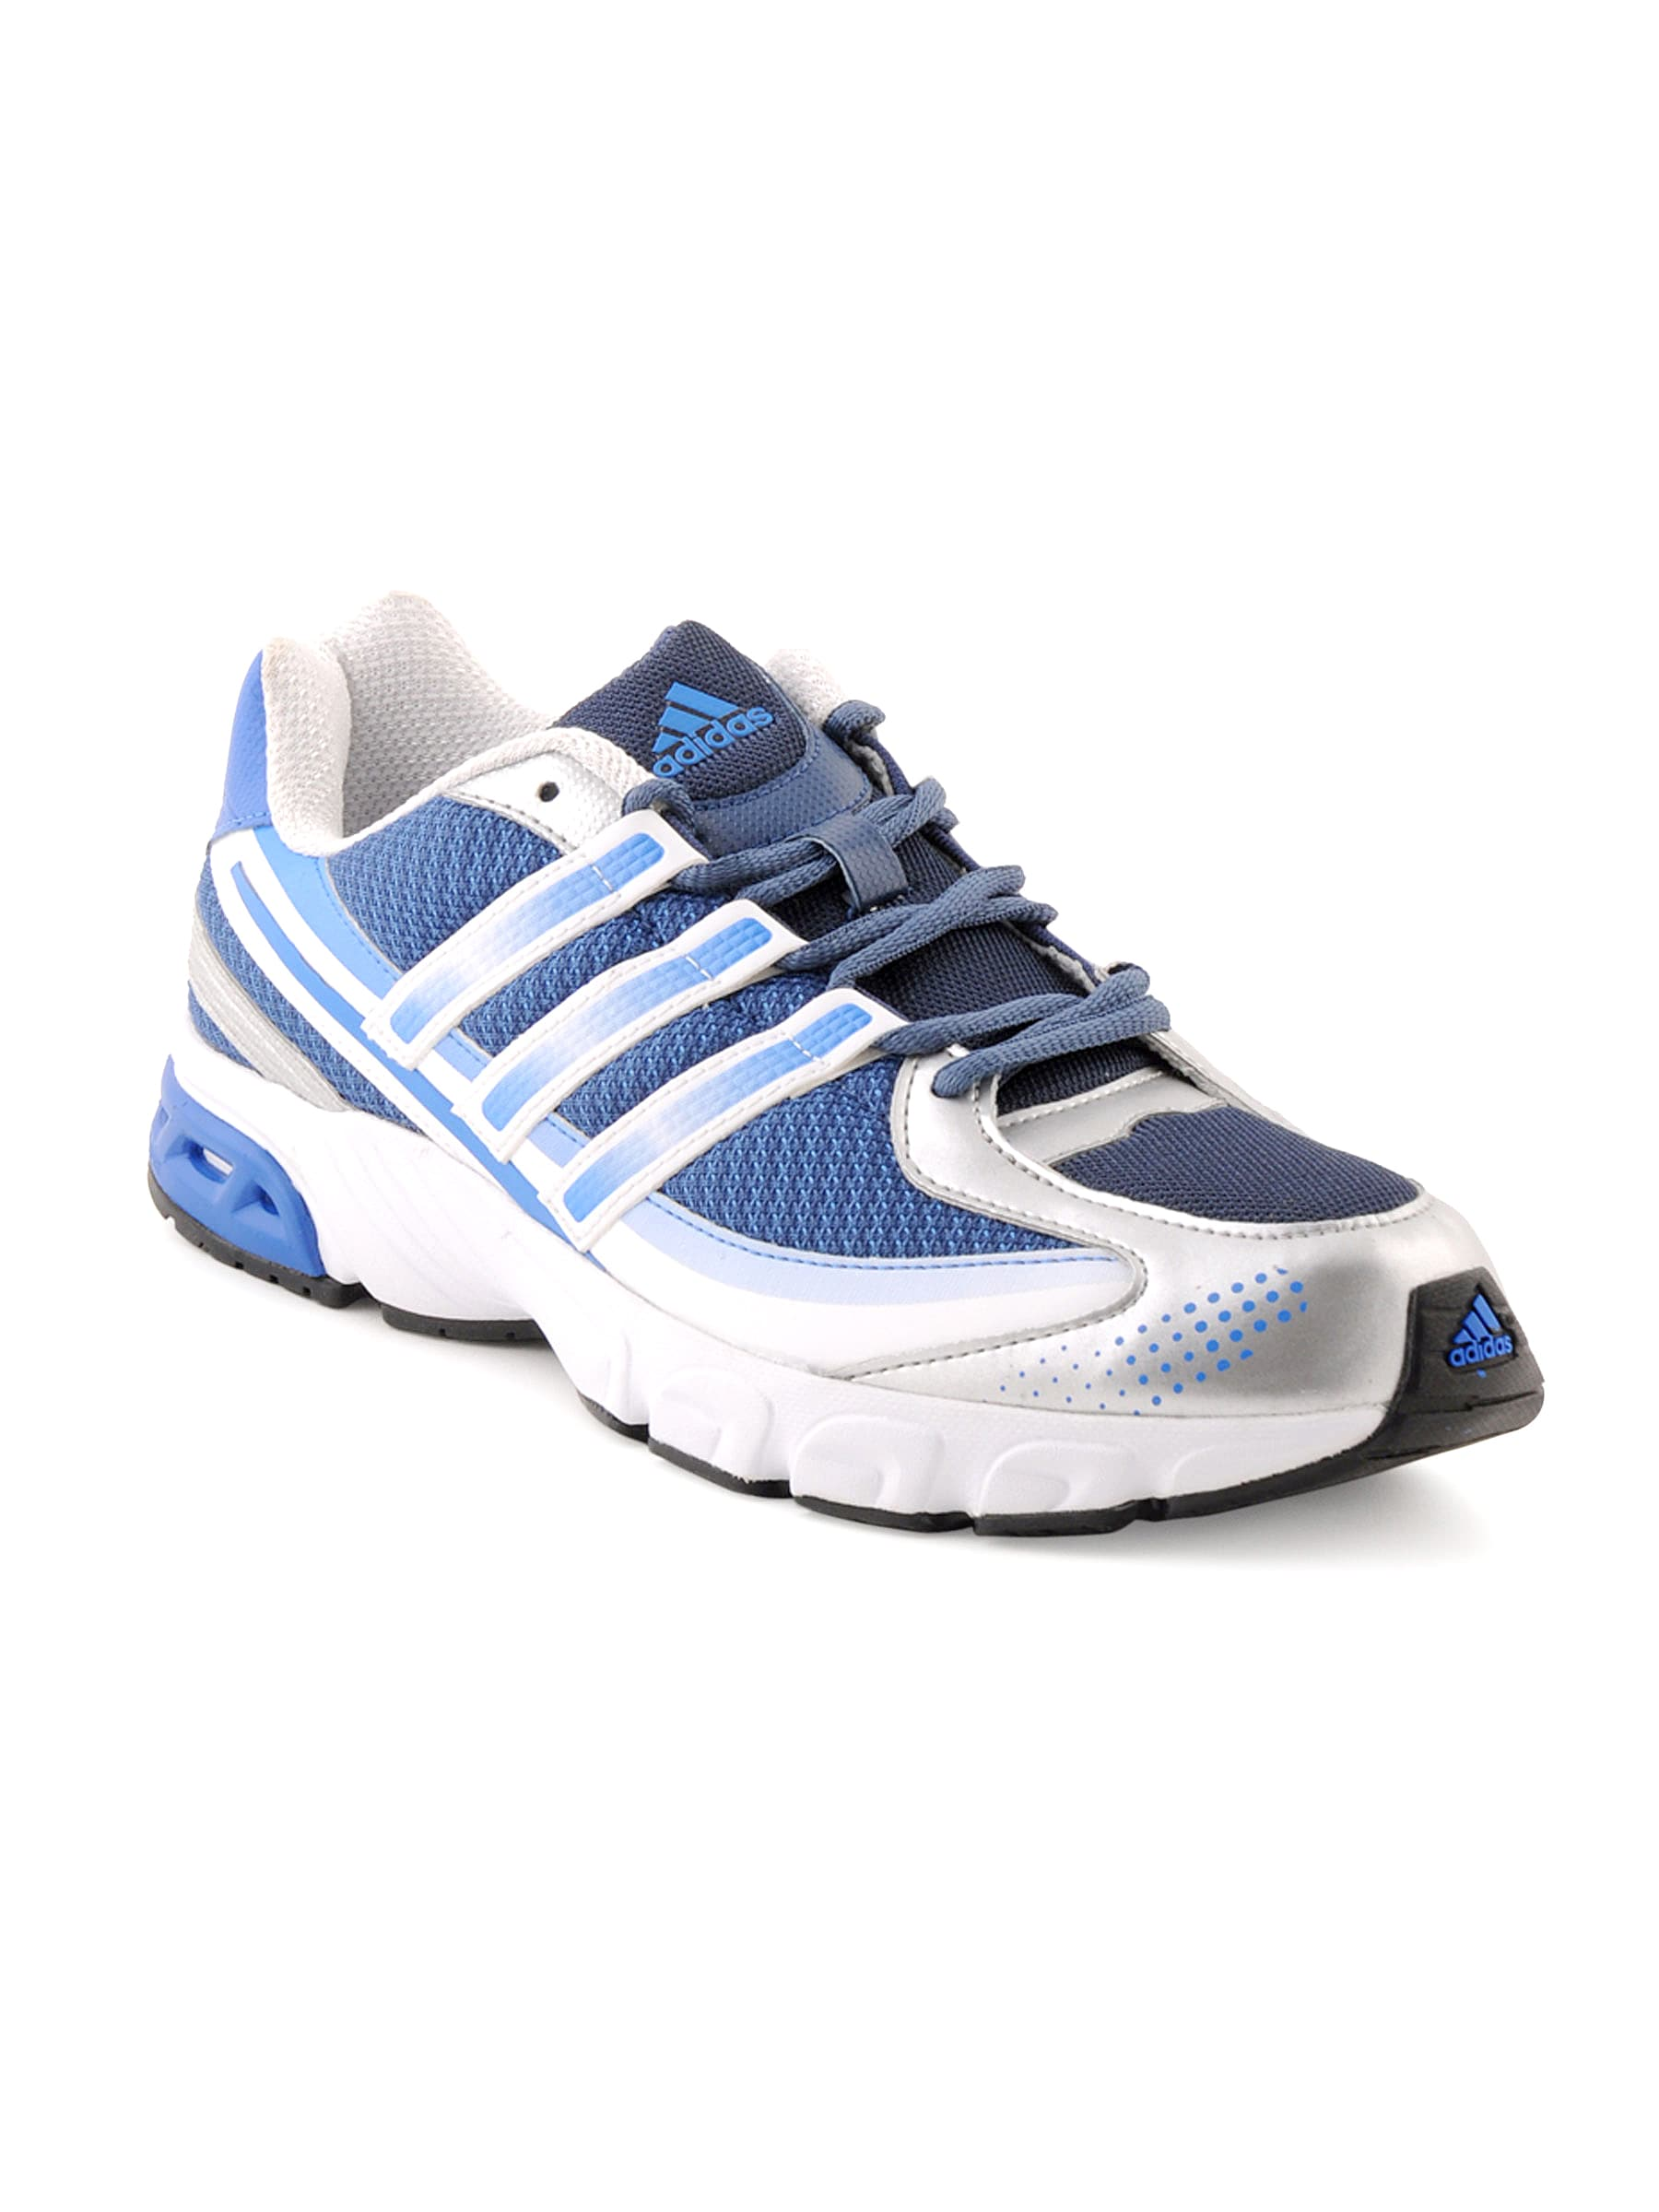

Product Title:  ADIDAS Men Adi Quest Blue Sports Shoes

 ==================== Recommended products ====================


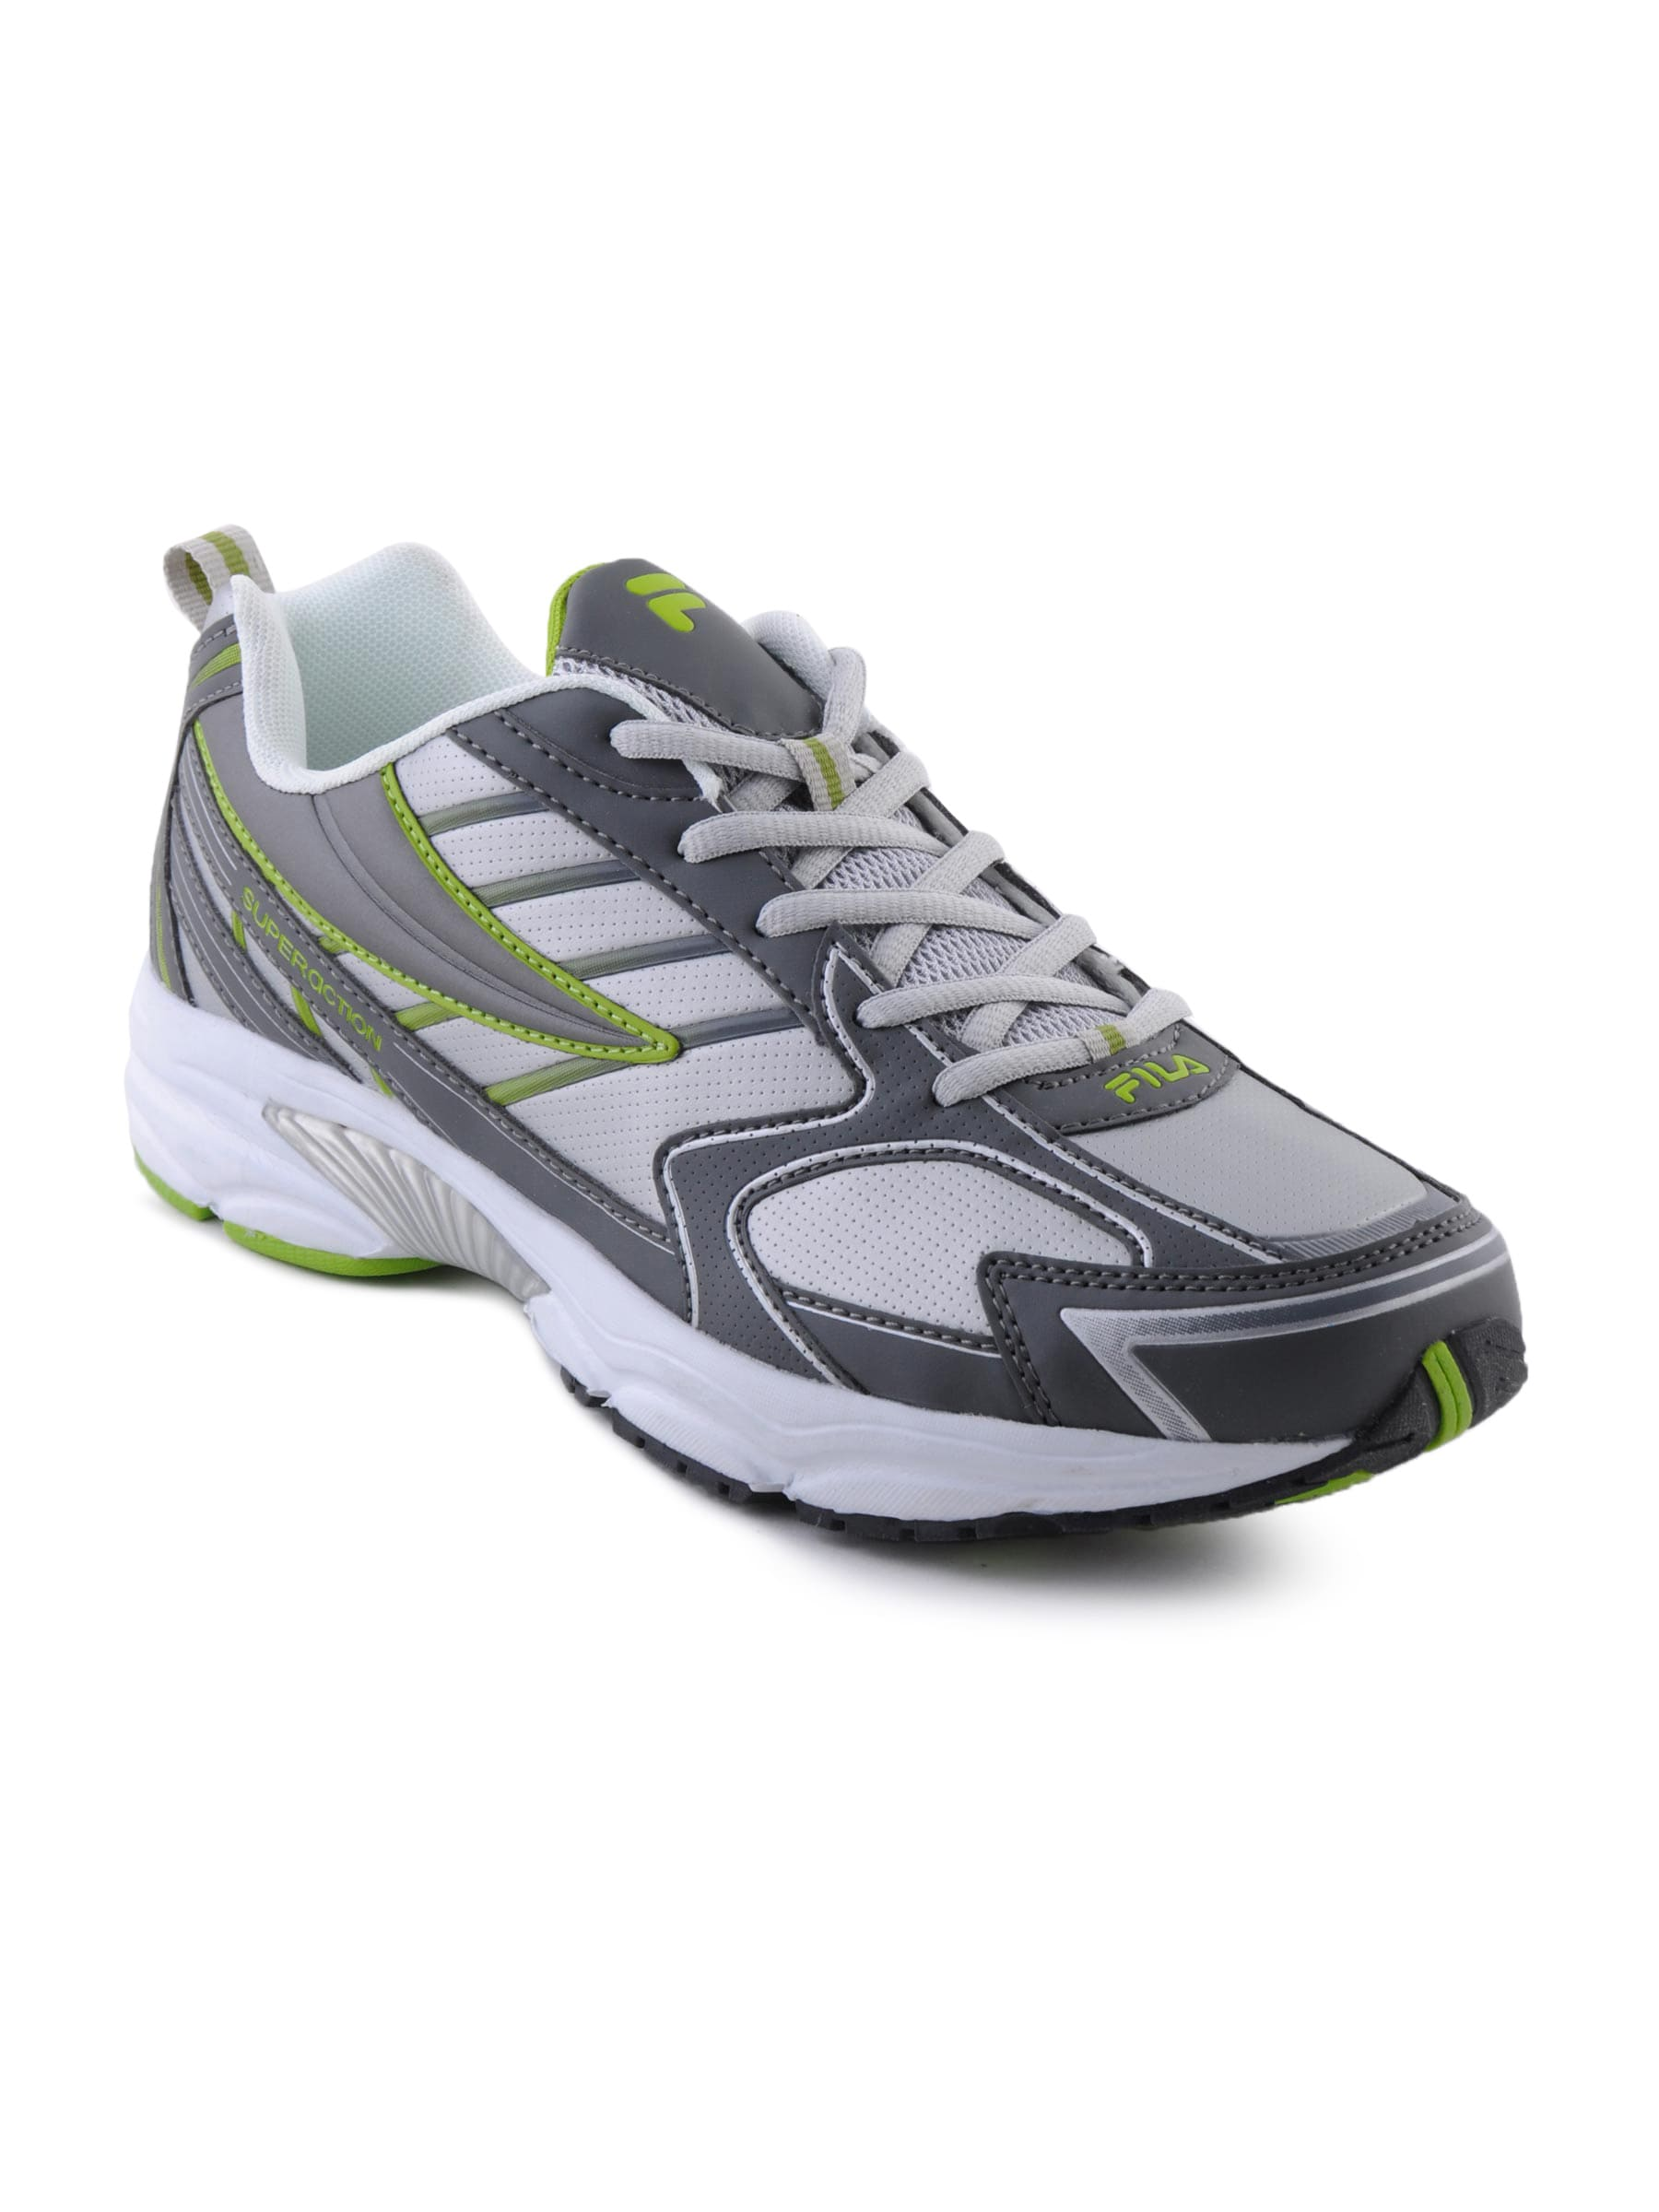

Product Title:  Fila Men Destiny Grey Sports Shoes
Euclidean Distance from input image: 27.646393


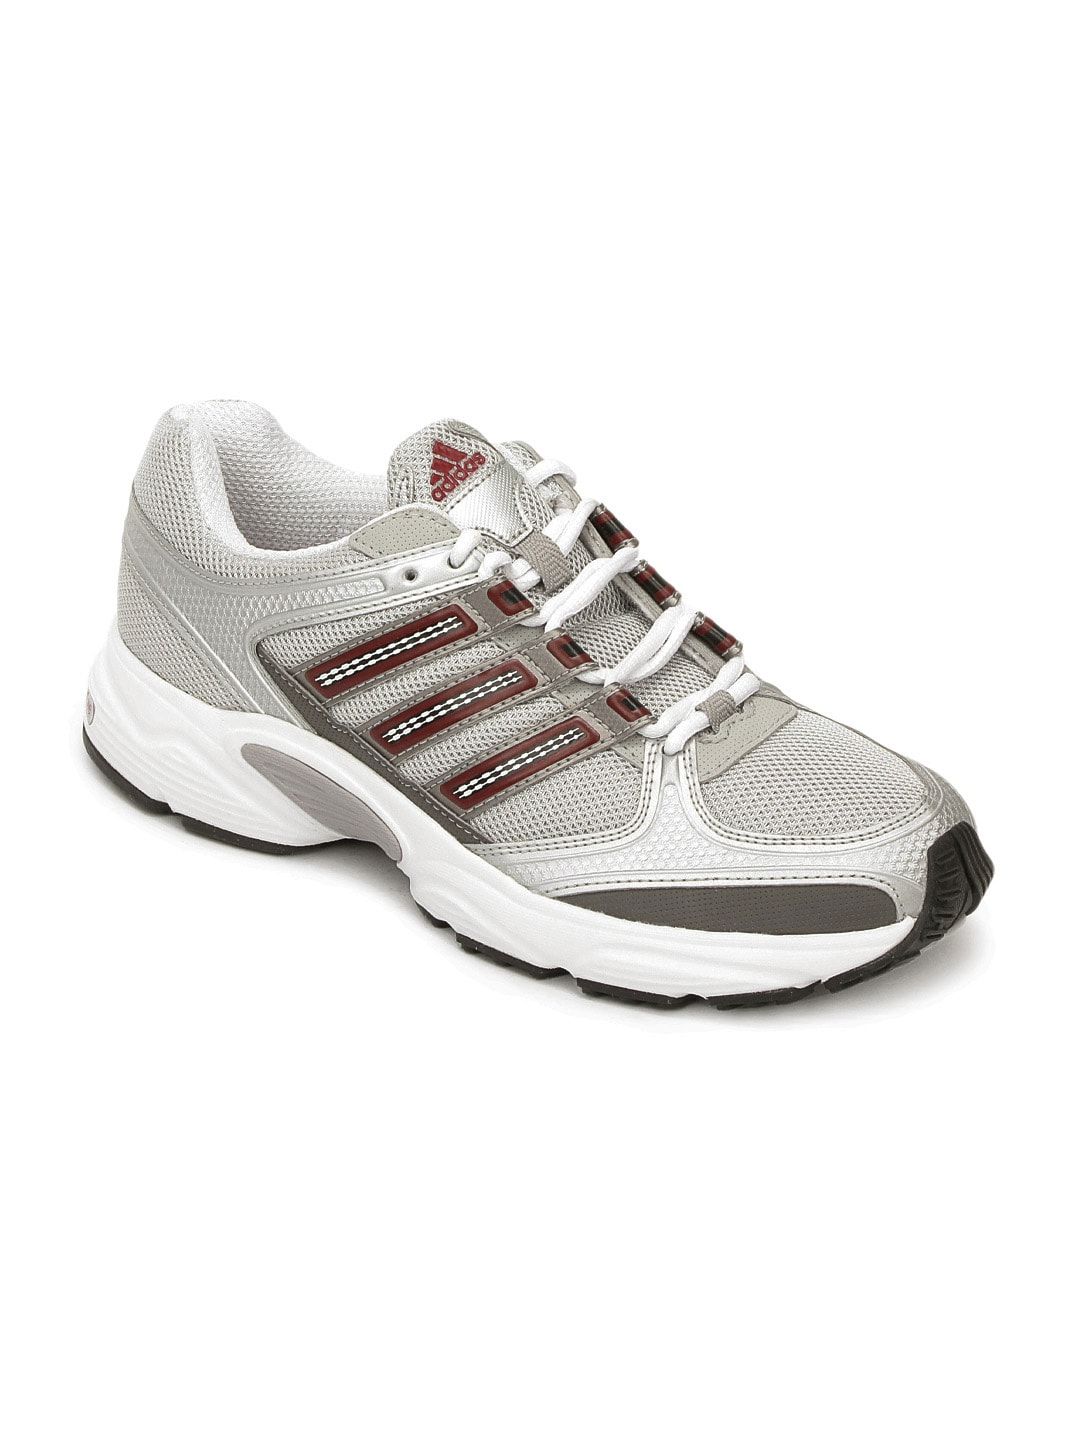

Product Title:  ADIDAS Men Silver Phaedra Shoes
Euclidean Distance from input image: 29.374018


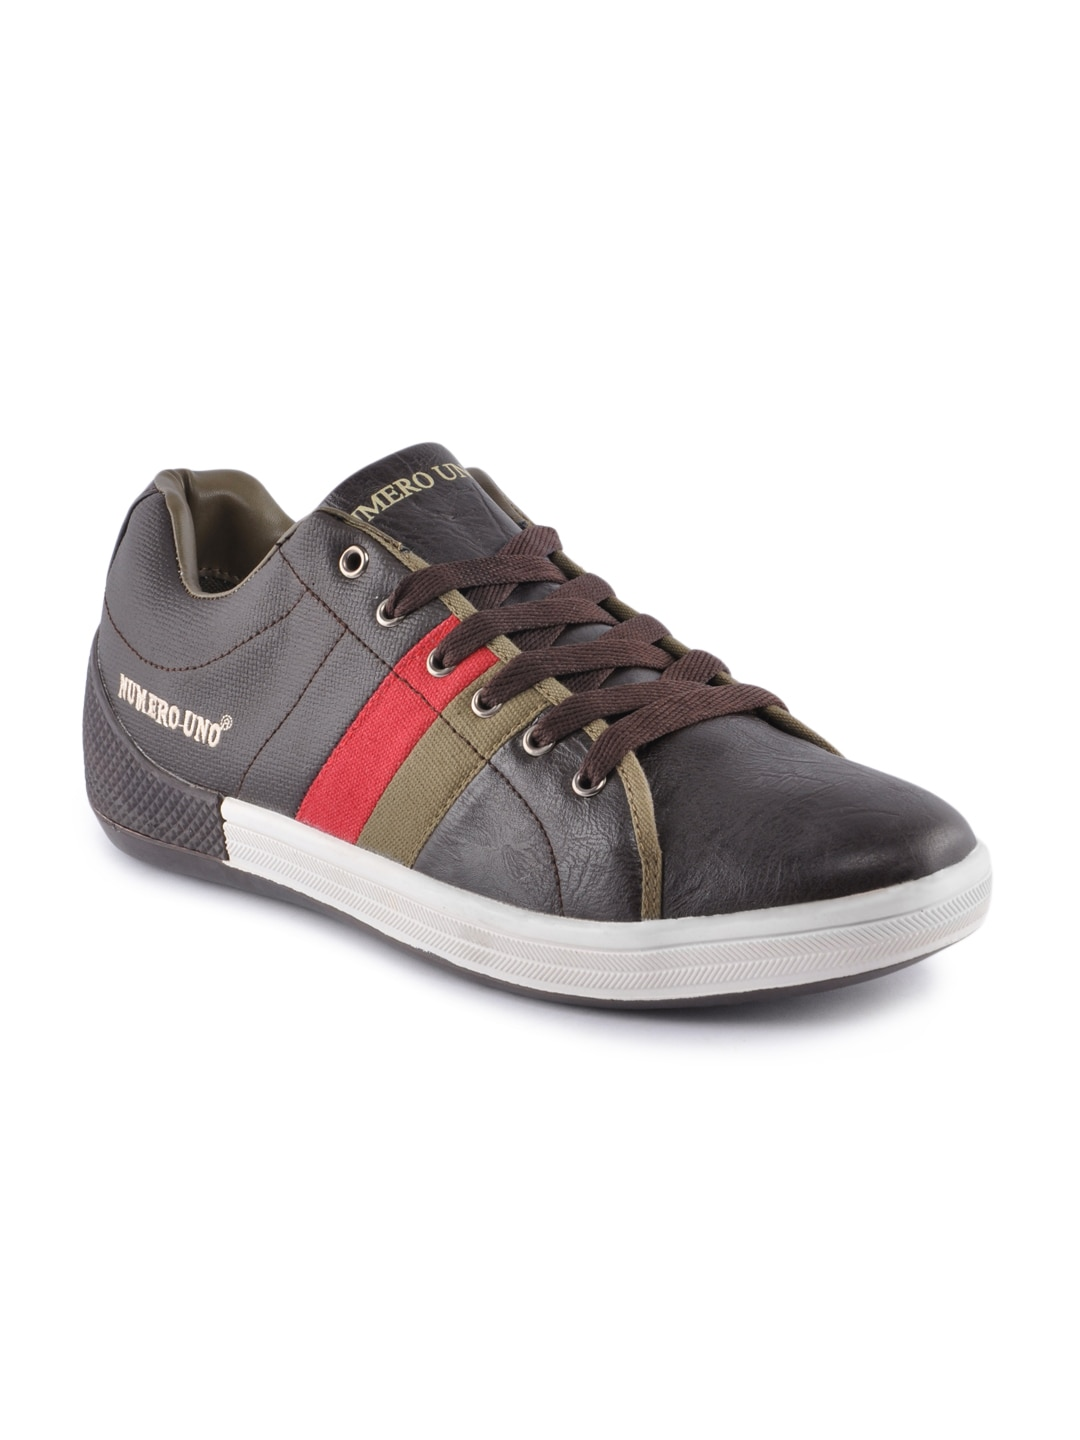

Product Title:  Numero Uno Men Brown Casual Shoes
Euclidean Distance from input image: 30.170906


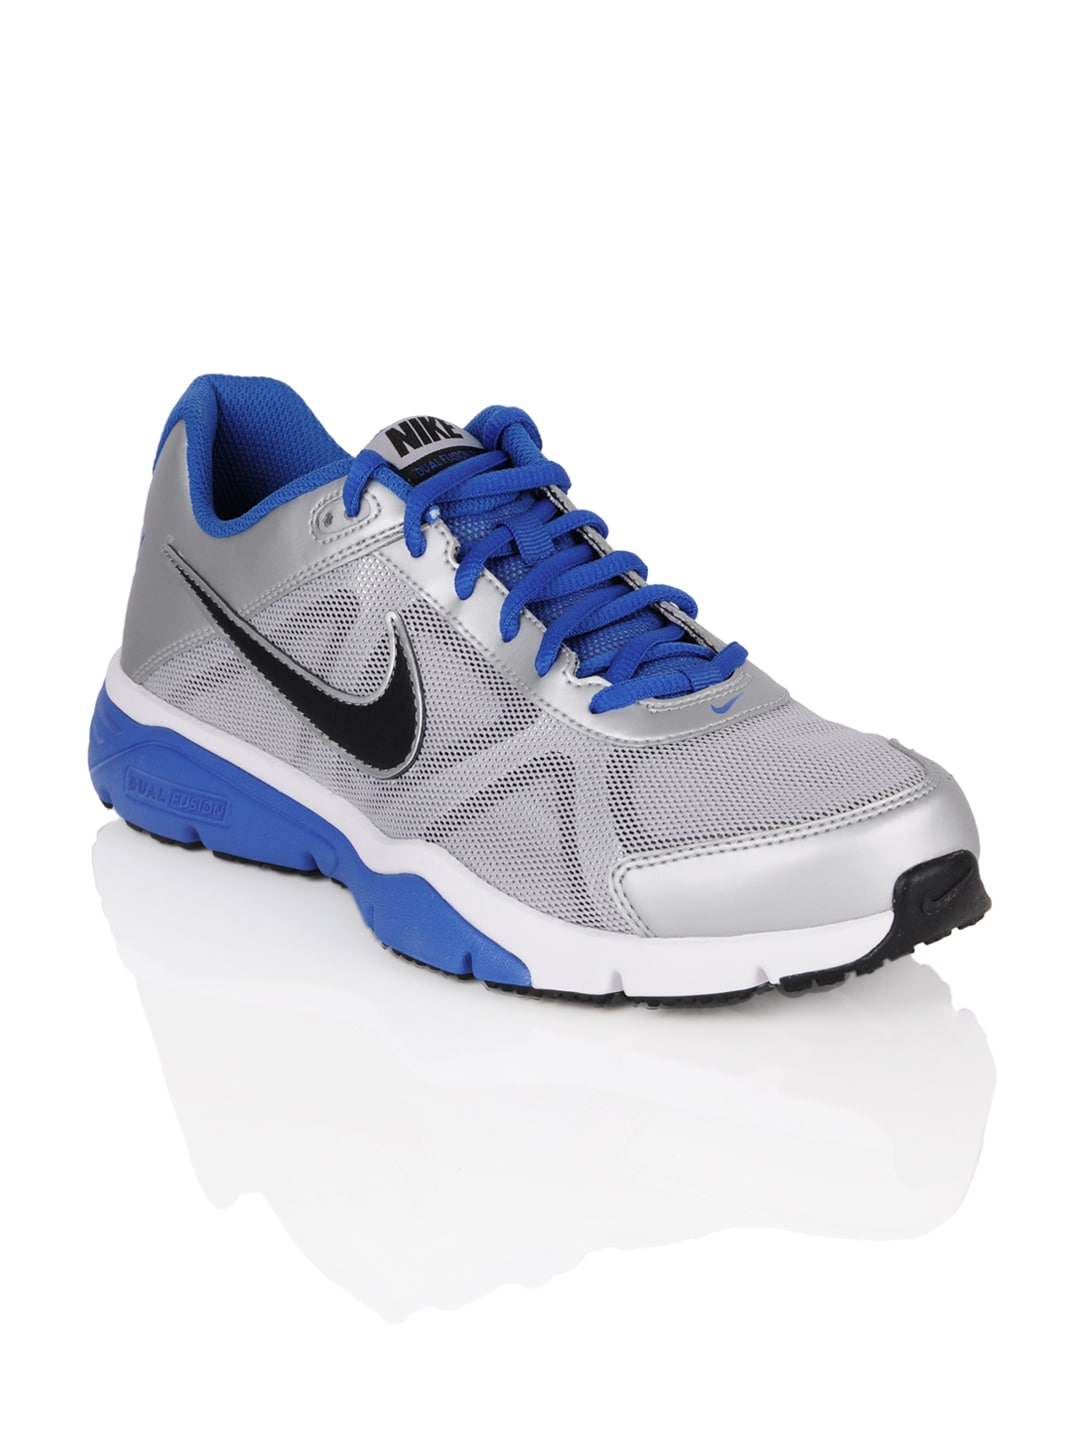

Product Title:  Nike Men Dual Fusion TR III Grey Sports Shoes
Euclidean Distance from input image: 30.894924


In [8]:
def get_similar_products_cnn(product_id, num_results):
    doc_id = Productids.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[0]])]
    #print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['ProductTitle'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])

get_similar_products_cnn('13683', 5)